# Tutorial 4: Building an End-To-End Multilingual Chat Application

Welcome the last tutorial of our course our class on "Practical Machine Translation for Low Resource Languages". Today, we will be learning how to make a Chat-Bot that answers Grade School level math word problems using the [OpenAI API](https://openai.com/blog/openai-api) and pair it with translation models that we have trained/evaluated in the previous classes to extend the capabilities of our bot on languages other than English.

Before geting started, we recommend signing up for a free-trial of the [OpenAI API](https://openai.com/blog/openai-api), which should give you free credits workth 18$ for three months. This should be plenty for the tutorial today and for your final projects. After signing up for the API, get the api key and place it in the `key.txt` file located in the same directory. Once that's setup you can proceed with the tutorial.

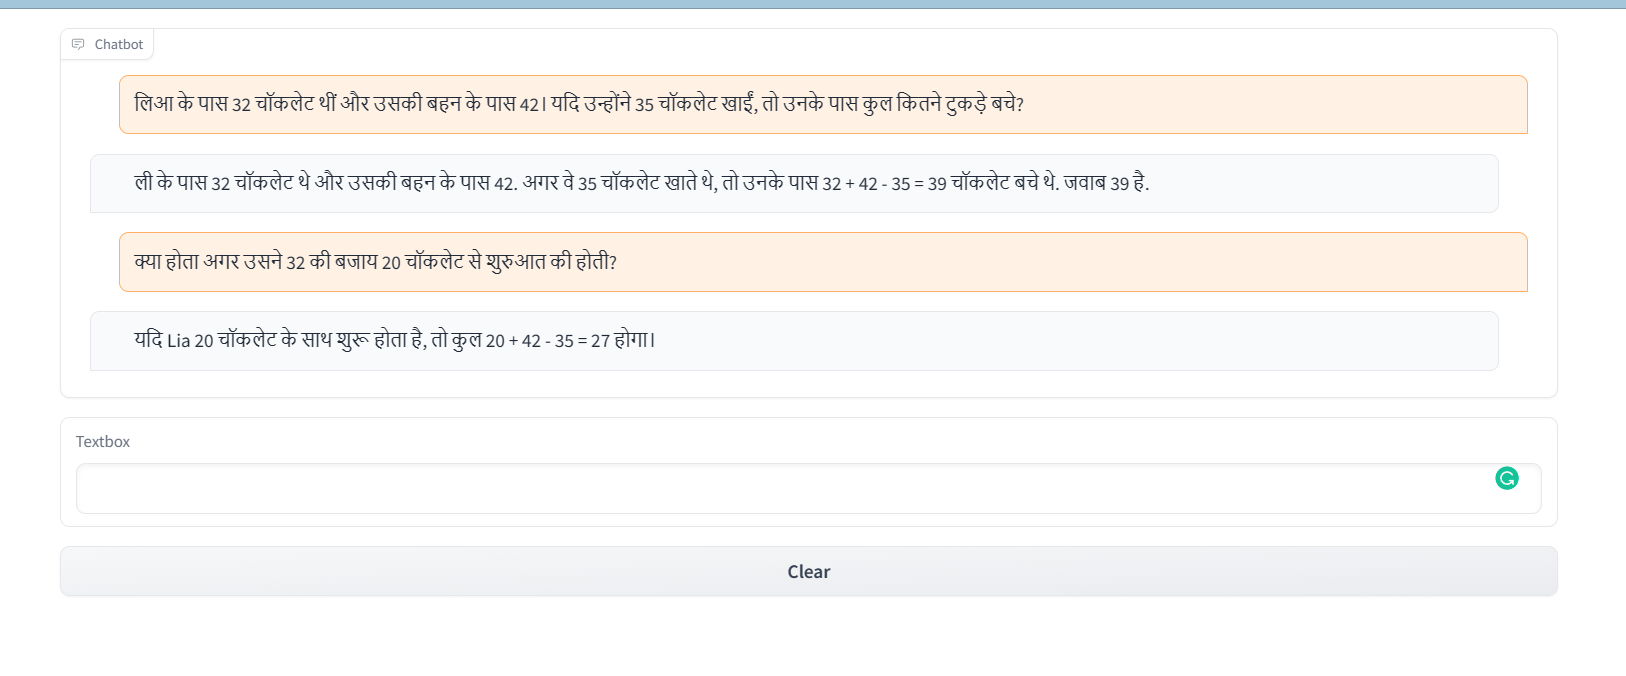

# Context 

As always we will start by installing the libraries we will be making use of today. Particularly we will install openai API to make call to GPT-3.5 models and [langchain](https://github.com/hwchase17/langchain) to augment the GPT-3.5 with capabilities to address some of its limitations.

In [ ]:
!pip install --upgrade openai
!pip install langchain==0.0.96
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.5/444.5 KB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import openai
import 

In [ ]:
# Specify the key
with open("/content/key.txt") as f:
    openai.api_key = f.read().split("\n")[0]

We will start by creating a math word problems question answering system in English using GPT-3.5. GPT is a pre-trained Large Language Model (LLM) with 175 Billion parameters, which is trained on a huge amount of unlabelled data using the language modelling objective (i.e. given k tokens, generate (k+1)th token). While this forms the basis of all GPT family of models, GPT-3.5 is based on [InstructGPT](https://arxiv.org/abs/2203.02155), which further adds an Instruction Tuning step that learns from human feedback to follow provided instructions.
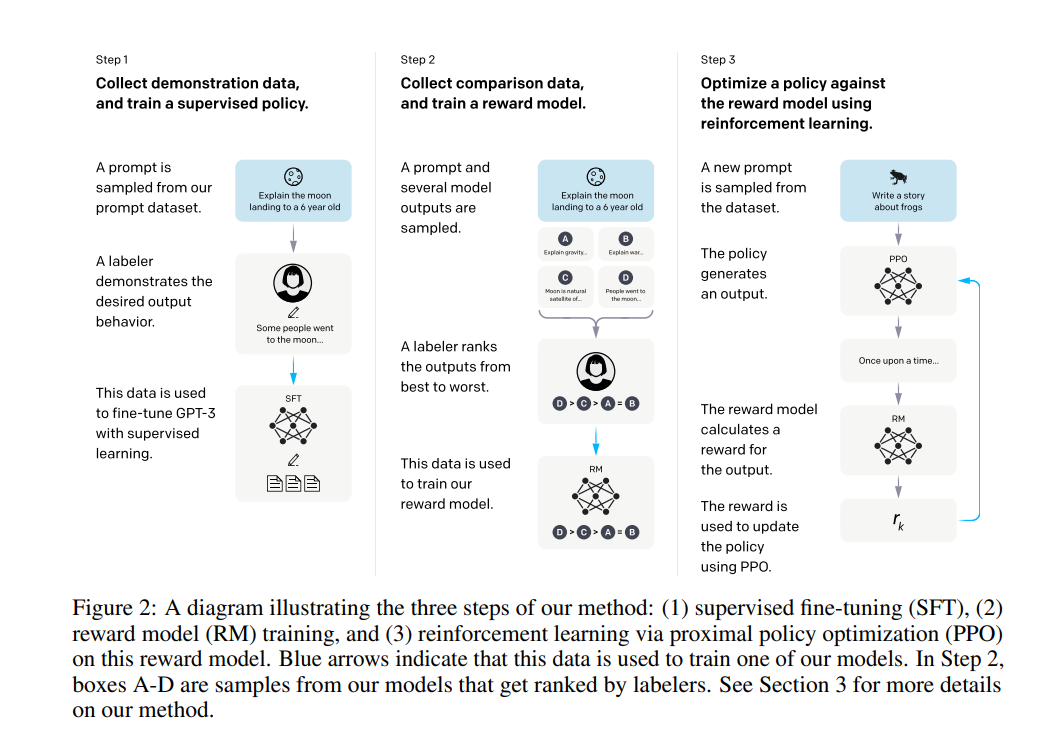
*From the [Ouyang et al. 2022](https://arxiv.org/abs/2203.02155)*

As a consequence of the pre-training with language modeling objective and instruction tuning, we can use GPT-3.5 to complete a given piece of text and provide specific instructions about how to go about completing the text. We achieve this by defining a text prompt which is to be given as the input to the LLM which then generates a completion of the provided text. Below we define a prompt template, containing instructions for our bot and provide a few examples of the type of problems it is supposed to solve. Finally, we define a placeholder {input} which is to be replace by different questions that user may ask followed by the text `Matt:` to instruct the model to generate response as the assistant `Matt`.

In [ ]:
template = """Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.

If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.

This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.

A few examples of a potential conversation can be:

Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?

Matt: The answer is 11.

Human: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?"

Matt: The answer is 29.

Human: {input}
Matt:"""

We will now see how we can hit the OpenAI API with a prompt to obtain the response from GPT-3.5. Below, we have implemented a function `answer_question` that does exactly that by performing two main steps:

1. Inserts the question asked by the user into the prompt template to construct the prompt to be fed to the LLM
2. Calls `openai.Completion.create` with the prompt to obtain the LLM's response.

In [ ]:
def answer_question(question):
    """Given a question asked by the user, hits the OpenAI API with a prompt to obtain the response from GPT-3.5.
    
    Inputs:
        - question (str): Question asked by the user
        
    Returns:
        (str): LLMs response
    
    
    """
    
    # Step 1: Insert the question asked by the user into the prompt template to construct the prompt to be fed to the LLM
    prompt = template.replace("{input}", question)
    
    # Step 2: Call `openai.Completion.create` with the prompt to obtain the LLM's response.
    response = openai.Completion.create(
        engine="text-davinci-003", #text-davinci-003 is the GPT-3.5 model
        prompt=prompt,
        temperature=0,# Useful for decoding by LLM, a temperature of 0 means fully deterministic greedy decoding
        max_tokens=100 # Maximum number of tokens that the LLM should generate especially for low resource lang, bcz for llm, we are tend to get more number of tokens
    )
    # The API returns other meta data as well, we are just concerened with the response text that can be obtained by doing:
    return response["choices"][0]["text"].strip()

For Paraphrased version HW, we can use different values of temperatures to get different paraphrased sentences

In [ ]:
answer_question("Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?")

'The answer is 39.'

In [ ]:
answer_question("The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?")

'The answer is 9.'

In [ ]:
answer_question("What is the best laptop in the market currently?")

"I'm sorry, I'm only a Math Assistant and I'm not able to answer that question."

In [ ]:
answer_question("For which real numbers x do the vectors: (x, 1, 1, 1), (1, x, 1, 1), (1, 1, x, 1), (1, 1, 1, x) not form a basis of R4?")

"I'm sorry, that is out of my capabilities. I'm only a Math Assistant and I can only answer simple grade school math word problems involving simple operators like addition, subtraction, division and multiplication. I advise you to take help from your teachers or parents."

In [ ]:
answer_question("Olivia has $23. She bought five bagels for $3 each. How much money does she have left?")

'The answer is $12.'

Look closely at the response above an you will realize that the LLM produces an incorrect response to the problem. We shall now see how to make our LLM more capable for solving such problems.

## Chain of Thought Prompting

One way to improve the reasoning capabilities of LLMs is [Chain-of-Thought (CoT) Prompting](https://arxiv.org/abs/2201.11903). In CoT we prompt the model to provide intermediate reasoning steps before predicting the final answer. This simple stragegy has been shown to improve the performance of LLMs (mainly the ones with > 100 billion parameters) significantly!

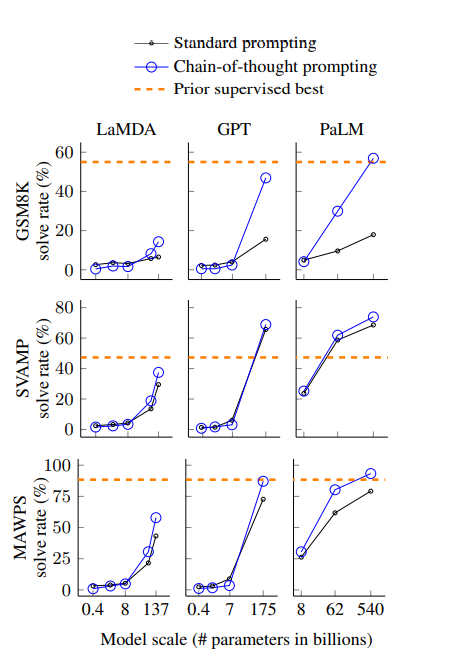
*From the [Wei et al. 2022](https://arxiv.org/abs/2201.11903)*

In the figure above, as you can see GPT with 175 billion parameters becomes significantly better at solving GSM8K task that involves solving grade school math word problems, which is exactly what we are try to do with our bot. Below we show how we can use CoT for our Math Assistant. We simply need to modify our prompt and provide intermediate steps of reasoning for the two examples that we provided before.

In [ ]:
template = """Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.

If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.

This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.

A few examples of a potential conversation can be:

Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
Matt: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11.


Human: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?"
Matt: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The answer is 29..

Human: {input}
Matt:"""

In [ ]:
answer_question("Olivia has $23. She bought five bagels for $3 each. How much money does she have left?")

'Olivia started with $23. She spent $3 for each bagel, so she spent 5 * 3 = 15. 23 - 15 = 8. The answer is 8.'

As can be seen the model is now able to solve the problem perfectly. Another consequence of CoT here is that response obtained is much more detailed and can be useful for both a better user experience as well as a better understanding if the model takes the correct steps to solve the problem.

In [ ]:
answer_question("Olivia has $23593456. She bought fifty six bagels for $3 each. How much money does she have left?")

'Olivia had $23593456. She spent $3 * 56 = $168 on bagels. She has $23593456 - $168 = $23593280 left. The answer is $23593280.'

And just when we thought we were done, we see another limitation of LLMs here. Particularly, here as you can see the LLM takes the correct reasoning steps and even predicts the correct equation `$23593456 - $168`, but gets the incorrect answer upon calculation. That is because LLMs are limited when it comes to performing mathematical operations with higher digit numbers.



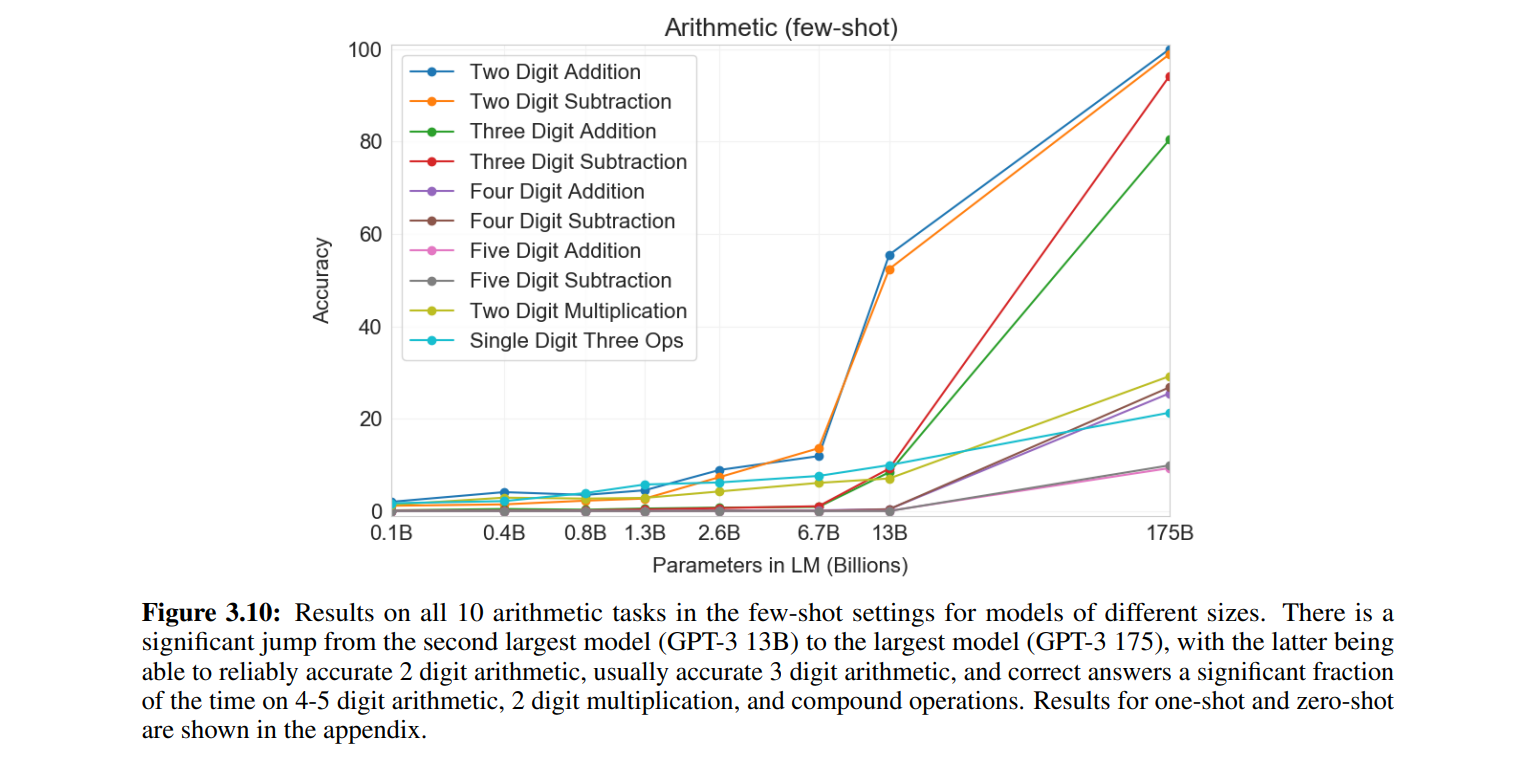
*From the [Brown et al. 2020](https://arxiv.org/abs/2005.14165)*

As can be seen in the plot above, while GPT with 175 billion parameters can solve up to 3-digit subtraction problem, the performance goes significantly down from 4 digits and above. We will next see how we can resolve limitations like these for such models.

## Chaining LLMs with other tools to improve their limitations

One observation that we can make from above is that the LLM did predict the reasoning steps and the equation for solving the problem correctly, which is the more complex part of solving these problems using computers. The actual execution of the equation that it failed at performing is something for which we already have tools like to do perfectly. Hence, we can prompt the LLM to just do what it is good at i.e. predicting the equation in this particular case and then use an external tool like a calculator or a python shell to execute the predicted equation. Below, we particularly prompt the LLM to predict the python code for solving the problem, which we can send to a python shell to execute and obtain the answer. This particular task of converting text description into an executable form is called [Semantic Parsing](https://en.wikipedia.org/wiki/Semantic_parsing), and is a well studied problem in NLP.

In [ ]:
sp_template = """Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.

If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.

This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.

A few examples of a potential conversation can be:

Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
Matt: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. PYTHON -> print(5 + 6)


Human: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?"
Matt: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so PYTHON -> print(4*5 + 9)

Human: {input}
Matt:"""

As can be seen now we have modified the prompt to answer in terms of python programs instead of the final answer of computation. Let's see if the model is able to generate the right program for execution:

In [ ]:
answer_question("Olivia has $23593456. She bought fifty six bagels for $3 each. How much money does she have left?")

'Olivia had $23593456. She spent $3 * 56 = $168 on bagels. She has $23593456 - $168 = $23593280 left. The answer is $23593280.'

As expected it does. We will now make use of the [langchain](https://github.com/hwchase17/langchain) library which provides many tools that can be combined with the LLMs to make them even more powerful. Here, we will be using the `python_repl` tool which acts as a python shell and can be used to execute any valid python command. Langchain has a bunch of other useful tools as well, and you can learn more about them [here](https://langchain.readthedocs.io/en/latest/modules/agents/tools.html)

In [ ]:
from langchain.agents import load_tools

In [ ]:
tools = load_tools(["python_repl"])

In [ ]:
tools

[Tool(name='Python REPL', description='A Python shell. Use this to execute python commands. Input should be a valid python command. If you expect output it should be printed out.', return_direct=False, verbose=False, callback_manager=<langchain.callbacks.shared.SharedCallbackManager object at 0x7ff56843be80>, func=<bound method PythonREPL.run of <langchain.python.PythonREPL object at 0x7ff5628fd4c0>>, coroutine=None)]

In [ ]:
python_shell = tools[0]

In [ ]:
python_shell("print(23593456 - 168)")

'23593288\n'

We can now re-define our `answer_question` function as `answer_question_with_python` that generates the response in terms of a python program, executes the program, and appends the output of Python shell to the final response to display to the user.

In [ ]:
def answer_question_with_python(question):
    
    prompt = sp_template.replace("{input}", question)
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        temperature=0,
        max_tokens=100
    )
    predicted_text = response["choices"][0]["text"].strip()
    
    if "PYTHON ->" in predicted_text:
        python_code = predicted_text.split("PYTHON ->")[-1].strip()
        answer = python_shell(python_code).strip()
        return predicted_text.replace(f"PYTHON -> {python_code}", f"The answer is {answer}")
    else:
        return predicted_text

In [ ]:
answer_question_with_python("Olivia has $23593456. She bought fifty six bagels for $3 each. How much money does she have left?")

'Olivia started with $23593456. She bought 56 bagels for $3 each. That means she spent 56 * 3 = 168 dollars. The answer is 23593288'

As can be sen the model now generates a correct response of the question.

In [ ]:
answer_question_with_python("Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?")

'Leah had 32 chocolates and her sister had 42. They ate 35 chocolates in total. So The answer is 39'

In [ ]:
answer_question("For which real numbers x do the vectors: (x, 1, 1, 1), (1, x, 1, 1), (1, 1, x, 1), (1, 1, 1, x) not form a basis of R4?")

'This question is out of my capabilities. I am only a Math Assistant and I can only answer simple grade school math word problems involving simple operators like addition, subtraction, division and multiplication. I advise you to take help from your teachers or parents.'

## Having conversations with LLM

Uptil now what we have is essentially a question answering system, from which we can ask multiple questions but cannot really have conversations, as it doesn't really remember the previous questions asked and answers it generated. However, it is very easy to implement such a behavior. We can simply store the conversation history till a particular instant and provide it as part of the prompt to the model so it can be aware of the previous turns of interaction. Doing this we can now ask cross questions about a particular problem, as shown below.

In [ ]:
class MathAssistant:
    
    """We will define a MathAssistant class which will store the history as one of its attributes
       so that it can remember the earlier conversations.
    """
    
    def __init__(self):
        
        
        # The template now has a placeholder for `{history}`
        self.template = """Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.
        If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.
        
        This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.
        
        A few examples of a potential conversation can be:
        
        Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
        
        Matt: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
        
        Human: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?"
        
        Matt: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The answer is 29..
        
        Human: What if there were 25 computers in the server room in the beginning.
        
        Matt: If there were 25 computers in the beginning, the total will be 20 + 25 = 45. The answer is 45.
        
        {history}
        
        Human: {input}
        Matt:"""
        
        
        # Defining the history
        self.history = ""
        
    def reset(self):
        self.history = ""
        
    def __call__(self, question):
        
        prompt = self.template.replace("{history}", self.history)
        prompt = prompt.replace("{input}", question)
        print(prompt)
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=prompt,
            temperature=0,
            max_tokens=100
        )
        response =  response["choices"][0]["text"].strip()
        
        # Update history
        self.history += f"\n\nHuman: {question}\n\nMatt: {response}"
        return response

In [ ]:
matt = MathAssistant()

In [ ]:
matt("Olivia has $23. She bought five bagels for $3 each. How much money does she have left?")

Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.
        If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.
        
        This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.
        
        A few examples of a potential conversation can be:
        
        Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
        
        Matt: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5

'Olivia started with $23. She spent $3 for each bagel, so she spent $3 * 5 = $15. She has $23 - $15 = $8 left. The answer is $8.'

In [ ]:
matt("What if she had bought 2 bagels instead of 5?")

Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.
        If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.
        
        This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.
        
        A few examples of a potential conversation can be:
        
        Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
        
        Matt: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5

'If she had bought 2 bagels instead of 5, she would have spent $3 * 2 = $6. She would have $23 - $6 = $17 left. The answer is $17.'

In [ ]:
matt("And what if she had 20$ to begin with?")

Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.
        If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.
        
        This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.
        
        A few examples of a potential conversation can be:
        
        Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
        
        Matt: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5

'If she had 20$ to begin with, she would have spent $3 * 5 = $15. She would have 20 - 15 = $5 left. The answer is $5.'

Equivalently, we can also use langchain for defining such behavior. It will automatically take care of storing previous history.

In [ ]:
from langchain import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

class MathAssistantWithLangChain(MathAssistant):
    
    def __init__(self, max_memory = 2, verbose = False):
        super().__init__()
        
        self.max_memory = max_memory
        self.verbose = verbose
        self.template = PromptTemplate(
            input_variables = ["history", "input"],
            template=self.template
        )
    
        self.llm_chain = LLMChain(
            llm=OpenAI(
                model_name="text-davinci-003",
                temperature=0,
                max_tokens=100,
                openai_api_key = openai.api_key
            ),
            prompt=self.template,
            verbose=self.verbose,
            memory=ConversationBufferWindowMemory(k=self.max_memory)
        )
        
    def reset(self):
        self.llm_chain = LLMChain(
            llm=OpenAI(
                model_name="text-davinci-003",
                temperature=0,
                max_tokens=100,
                openai_api_key = openai.api_key
            ),
            prompt=self.template,
            verbose=self.verbose,
            memory=ConversationBufferWindowMemory(k=self.max_memory)
        )
        
    
    def __call__(self, question):
        return self.llm_chain.predict(input=question)    

In [ ]:
matt = MathAssistantWithLangChain(2, verbose=True)

In [ ]:
matt("Olivia has $23. She bought five bagels for $3 each. How much money does she have left?")



> Entering new LLMChain chain...
Prompt after formatting:
Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.
        If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.
        
        This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.
        
        A few examples of a potential conversation can be:
        
        Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
        
        Matt: Roger started with

' Olivia started with $23. She spent $3 for each bagel, so she spent $3 * 5 = $15. She has $23 - $15 = $8 left. The answer is $8.'

In [ ]:
matt("What if she had bought 2 bagels instead of 5?")



> Entering new LLMChain chain...
Prompt after formatting:
Your name is Matt, a virtual assistant for answering simple grade school math word problems involving simple operators like addition , subtraction, division and multipication.
        If the math problem asked is more complex than what specified above, like if it involves concepts from probability or calculus, try answering that but warn the user that it might be out of your capabilities and you advise the user to take help from their teachers or parents.
        
        This is the only thing that you are capable of. If the user asks about some topic other than math, just say that you are only Math Assistant and it is out of your capability to answer the question.
        
        A few examples of a potential conversation can be:
        
        Human: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
        
        Matt: Roger started with

' If she had bought 2 bagels instead of 5, she would have spent $3 * 2 = $6. She would have $23 - $6 = $17 left. The answer is $17.'

## Making the Assistant work for Languages other than English

For the final part of the tutorial we will be making are Math Assistant to work for languages other than English. Particularly, we will be demonstrating the use-case for Hindi. Since, GPT models are predominantly trained with English data, their capabilities for other languages, especially low-resource languages are very limited. One way to improve their capabilities in other languages is to augment these models with Machine Translation (MT) systems. It mainly involves three steps:

1. Use an MT system to first translate the user query to English
2. Feed the translated query to LLM to obtain response in English
3. Translate the English response to the user's language

We will be using 🤗 transformers library to load translation pipelines as demonstrated in the Tutorial 1 and in particular will be using the [M2M model by Meta](https://about.fb.com/news/2020/10/first-multilingual-machine-translation-model/) that is able to translate to and from 100 languages.

In [ ]:
from transformers import pipeline

In [ ]:
class MultilingualMathAssistant(MathAssistantWithLangChain):
    
    def __init__(self, lang, max_memory = 2, verbose = False):
        super().__init__(max_memory, verbose)
        
        self.lang = lang
        self.translation_pipeline = pipeline('text2text-generation', model="facebook/m2m100_418M") #m2m means many to many, uses classes of languages for translation rather than simple 1 to 1 learing and translation
        
        
    def translate_lang_to_en(self, text):
        
        # For M2M, we need to specify the langauge to translate to as a BOS token to the decoder i.e. in this case "en"
        return self.translation_pipeline(text, forced_bos_token_id = self.translation_pipeline.tokenizer.get_lang_id('en'))[0]["generated_text"]

        #lang-id to tell which language to use for the translation

    def translate_en_to_lang(self, text):
        
        # For M2M, we need to specify the langauge to translate to as a BOS token to the decoder i.e. in this case `self.lang`
        return self.translation_pipeline(text, forced_bos_token_id = self.translation_pipeline.tokenizer.get_lang_id(self.lang))[0]["generated_text"]
    
    def __call__(self, question):
        
        # Translate question to English
        en_question = self.translate_lang_to_en(question)
        
        # Obtain the response in English
        en_response = super().__call__(en_question)
        
        # Translate the response to the bots language
        lang_response = self.translate_en_to_lang(en_response)
        
        return lang_response
        

In [ ]:
matt_hi = MultilingualMathAssistant("hi")

In [ ]:
matt_hi("लिआ के पास 32 चॉकलेट थीं और उसकी बहन के पास 42। यदि उन्होंने 35 चॉकलेट खाईं, तो उनके पास कुल कितने टुकड़े बचे?")

'ली के पास 32 चॉकलेट थे और उसकी बहन के पास 42. अगर वे 35 चॉकलेट खाते थे, तो उनके पास 32 + 42 - 35 = 39 चॉकलेट बचे थे. जवाब 39 है.'

In [ ]:
matt_hi("लिविया के पास 23 डॉलर हैं। उसने $ 3 प्रत्येक के लिए पाँच बैगेल खरीदे। उसके पास कितना पैसा बचा है?")

'लीबिया के पास $ 23 था. उसने प्रत्येक $ 3 के लिए 5 बैग खरीदे, इसलिए उसने $ 15 खर्च किया. उसने $ 23 बचाया - $ 15 = $ 8. जवाब $ 8 है.'

Now, that we have all the components ready for building our mutlilingual Math Assistant, we can create a we app using [Gradio](https://gradio.app/), to build an interactive solution which we can later deploy! Head on to [app.py](app.py) for the implementation of the same.